# General

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.nn as nn
import torchvision.models
import torchvision.utils
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.model_selection import train_test_split
!pip install torchmetrics
import gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
folder_path = '/content/drive/MyDrive/DS-LAB1/'
train_dataset_path = folder_path + 'train_data.npy'
train_labels_path = folder_path + 'train_labels.npy'
test_dataset_path = folder_path + 'val_data.npy'
test_labels_path = folder_path + 'val_labels.npy'

classes = [ "bg","RoadMarkings","Tree","Building","Vehicle","Person",
            "LifeguardChair","PicnicTable","BlackWoodPanel",
            "WhiteWoodPanel","OrangeLandingPad","Buoy","Rocks",
            "LowLevelVegetation","Grass_Lawn","Sand_Beach",
            "Water_Lake","Water_Pond","Asphalt"]; 

# Utils function

In [4]:
# Inevert the one-hot encoding
def decode_mask(img):
  array = np.zeros(256*256).reshape(256,256)
  for i in range(array.shape[0]):
    for j in range(array.shape[1]):
      array[i][j] = np.argmax(img[i][j])
  return Image.fromarray(array.astype(np.uint8))

# Get an image with the differnce between the target and the pred
def sim(target, pred):
  sim_arr = np.zeros(256*256).reshape(256,256)
  a1 = np.asarray(target)
  a2 = np.asarray(pred)
  for i in range(256):
    for j in range(256):
      sim_arr[i][j] = 1 if a1[i][j] == a2[i][j] else 0
  return sim_arr

# plot list of images
def img2plot(model, loader,l):
  images = []
  for i in l:
    data, target = get_loader_sample(i,dataloader=loader,batch_size=1)
    with torch.no_grad():
      output = model(data.to(device=device))
    out = output[0]
    m = nn.Softmax()
    test = m(output)
    out = test[0]
    out = np.rollaxis(out.to(device='cpu').detach().numpy(),0,3)
    img = np.rollaxis(data[0].to(device='cpu').detach().numpy(),0,3)
    t = target[0]
    t = np.rollaxis(t.detach().numpy(),0,3)

    masked_target = decode_mask(t.copy())
    masked_pred = decode_mask(out.copy())
    sim_arr = sim(masked_target.copy(), masked_pred.copy())
    masked_sim = Image.fromarray(sim_arr.astype(np.uint8))
    img_rgb = get_rgb(img)

    images.append(masked_target)
    images.append(masked_pred)
    images.append(img_rgb)
    images.append(masked_sim)
  return images

# Load the dataset from a numpy file
def load_npy(path):
    return np.load(path)

# Rescale the image pixel values to plot it
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

# To plot the RGB channels of the image
def get_rgb(img, loader_image=False):
    if loader_image:
      img = np.rollaxis(img.to(device='cpu').detach().numpy(),0,3)
    r = rescale(img[:,:,2])
    g = rescale(img[:,:,1])
    b = rescale(img[:,:,0])
    rgb_uint8 = (np.dstack([r,g,b]) * 255.999) .astype(np.uint8)
    return Image.fromarray(rgb_uint8, 'RGB')

# Load the data and the target from numpy files
def load_data():
    dataset_rw = load_npy(train_dataset_path).astype('float32')
    target_rw = load_npy(train_labels_path).astype('float32')
    target_rw = np.rollaxis(target_rw,3,1)
    target_rw = torch.from_numpy(target_rw)
    return dataset_rw, target_rw

def load_test_data():
    test_dataset_rw = load_npy(test_dataset_path).astype('float32')
    test_target_rw = load_npy(test_labels_path).astype('float32')
    test_target_rw = np.rollaxis(test_target_rw,3,1)
    test_target_rw = torch.from_numpy(test_target_rw)
    return test_dataset_rw, test_target_rw

# Get list of samples from the pytorch dataloader
def get_loader_sample(idx, dataloader, batch_size = 1):
  k = int(np.floor(idx/batch_size))
  return next(itertools.islice(dataloader, k, None))

# Hyper parameters

In [5]:
lr = 0.0016
num_epochs = 30
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64 # 64, 32, 16
num_workers = 2
h = 256 
w = 256  
num_channels = 6
num_classes = 19
pin_memory = True
load_model = False
random_state=12

# Dataset and Loaders

In [6]:
X, y = load_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)
dataset_len = {
    'train': len(X_train),
    'val': len(X_val)
}

In [7]:
class RIT18Dataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:

def get_loaders(X_train, y_train, X_val, y_val):
    trans = transforms.Compose([
    transforms.ToTensor(),
    ])
    train_ds = RIT18Dataset(X_train, y_train, trans)

    train_loader =  DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True,
        shuffle=True,
    )

    val_ds = RIT18Dataset(X_val, y_val, trans)
    val_loader =  DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True,
        shuffle=False,
    )

    del X_train, y_train, X_val, y_val
    gc.collect()
    return train_loader, val_loader


def get_test_loader(X,y):
    trans = transforms.Compose([
    transforms.ToTensor(),

    ])

    test_ds = RIT18Dataset(X, y, trans)
    test_loader =  DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
        drop_last=True, 
    )
    del X, y
    gc.collect()
    return test_loader

In [9]:
train_loader, val_loader = get_loaders(X_train, y_train, X_val, y_val)

In [10]:
del X, X_train, X_val, y, y_train, y_val
gc.collect()
X_test, y_test = load_test_data()
dataset_len['test']=len(X_test)
test_loader = get_test_loader(X_test, y_test)

# LinkNet with ResNet Backbone

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import resnet

class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_channels),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Encoder(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_channels, out_channels, kernel_size, stride, padding, groups, bias)
        self.block2 = BasicBlock(out_channels, out_channels, kernel_size, 1, padding, groups, bias)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


class Decoder(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, in_channels//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_channels//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_channels//4, in_channels//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_channels//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels//4, out_channels, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [12]:
class LinkResNet(nn.Module):
    def __init__(self,n_channels=6, n_classes=19):
        super(LinkResNet, self).__init__()

        base = resnet.resnet18(pretrained=True)

        self.in_block = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3,bias=False),
            base.bn1,
            base.relu,
            base.maxpool
        )

        self.encoder1 = base.layer1
        self.encoder2 = base.layer2
        self.encoder3 = base.layer3
        self.encoder4 = base.layer4

        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)

    def forward(self, x):
        # Initial block
        x = self.in_block(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder blocks
        d4 = e3 + self.decoder4(e4)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)

        return y

# Training

## Train Functions

In [13]:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(path, model):
    checkpoint = torch.load(path)
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def print_acc(tr_acc,v_acc):
  print(f'idx\tClasses\t\ttrain\tval')
  for i,(x,y) in enumerate(zip(tr_acc,v_acc)):
    if i == 0:continue
    print(f'{i+1}\t{classes[i]} {x:.4f}\t{y:.4f}')
  print(f'Average: {tr_acc.mean():.4f},{v_acc.mean():.4f}')

def print_single_acc(acc):
  print(f'idx\tClasses\t\tAccuarcy')
  for i,x in enumerate(acc):
    if i == 0:continue
    print(f'{i+1}\t{classes[i]} {x:.4f}')
  print(f'Average: {acc.mean():.4f}')

import torchmetrics
def check_accuracy(loader, model, device="cuda", check_type='val'):
    
    model.eval()
    accuracy = {};
    acc_per_class = np.zeros(num_classes)
    for i in range(0,num_classes):
      accuracy[i] = torchmetrics.Accuracy(ignore_index=0)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            preds = nn.Softmax(dim=1)(model(x))
            preds = (preds > 0.5).float()
            preds = preds.cpu()
            for j in range(preds.shape[1]):
              for i in range(preds.shape[0]):
                 a1 = preds[i][j].flatten().to(torch.long)
                 a2 = y[i][j].flatten().to(torch.long)
                 accuracy[j](a1,a2)
    for i in range(1,num_classes):
        acc = accuracy[i].compute()
        acc_per_class[i] = acc

    model.train()
    return acc_per_class

def train_model(loader, model, optimizer, loss_fn, scaler, phase='train'):
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device=device)
        targets = targets.float().to(device=device)

        optimizer.zero_grad()
        # forward
        with torch.set_grad_enabled(phase == 'train'):
            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions, targets)

            if phase == 'train':
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
        # statistics
        running_loss += loss.item() * data.size(0)

    return running_loss /dataset_len[phase]

def train(path2save,loader, model, optimizer, loss_fn, scaler):
    loss_values = {
        'train': [],
        'val': []
    }
    accuarcy_values = {
        'train':[],
        'val': []
    }
    # To save the best model
    best_accuracy = 0

    # For Early Stopping
    last_loss = None
    patience = 2
    triggertimes = 0
    
    for epoch in range(num_epochs):
        
        model.train()
        train_loss = train_model(loader['train'], model, optimizer, loss_fn, scaler, phase='train')
        loss_values['train'].append(train_loss)
        model.eval()
        val_loss = train_model(loader['val'], model, optimizer, loss_fn, scaler, phase='val')
        loss_values['val'].append(val_loss)
        checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer":optimizer.state_dict(),
            }

        print(f'Epoch {epoch}: Train Loss: {train_loss:.2f}, Val loss: {val_loss:.2f}')
       
    return loss_values, accuarcy_values

In [14]:
def get_link_resnet_model(freeze=False):
  model = LinkResNet(num_channels,num_classes)
  model = model.to(device)
  if freeze:
    for l in [model.in_block,model.encoder1, model.encoder2, model.encoder3, model.encoder4]:
      for param in l.parameters():
        param.requires_grad = False
  return model

In [15]:
models = {
    'link_res':{
        'model': get_link_resnet_model(),
        'path': folder_path + 'models/linknet_resnet_with_cel_check_points.pt'
    }
}
loss_values = {}
accuracy_values = {}

## Train LinkNet

#### Load or Create the model

In [ ]:
model_name = 'link_res'

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.27, Val loss: 2.20
Epoch 1: Train Loss: 1.61, Val loss: 2.05
Epoch 2: Train Loss: 1.38, Val loss: 1.81
Epoch 3: Train Loss: 1.27, Val loss: 1.13
Epoch 4: Train Loss: 1.20, Val loss: 1.31
Epoch 5: Train Loss: 1.16, Val loss: 1.68
Epoch 6: Train Loss: 1.12, Val loss: 1.06
Epoch 7: Train Loss: 1.11, Val loss: 1.24
Epoch 8: Train Loss: 1.03, Val loss: 1.19
Epoch 9: Train Loss: 1.02, Val loss: 1.02
Epoch 10: Train Loss: 0.99, Val loss: 1.03
Epoch 11: Train Loss: 0.97, Val loss: 0.93
Epoch 12: Train Loss: 0.95, Val loss: 1.41
Epoch 13: Train Loss: 0.97, Val loss: 0.85
Epoch 14: Train Loss: 0.98, Val loss: 0.81
Epoch 15: Train Loss: 0.91, Val loss: 0.81
Epoch 16: Train Loss: 0.90, Val loss: 1.32
Epoch 17: Train Loss: 0.86, Val loss: 0.78
Epoch 18: Train Loss: 0.92, Val loss: 0.92
Epoch 19: Train Loss: 0.90, Val loss: 0.88
Epoch 20: Train Loss: 0.86, Val loss: 0.88
Epoch 21: Train Loss: 0.81, Val loss: 0.74
Epoch 22: Train Loss: 0.90, Val loss: 0.76
Epoch 23: Train Loss:

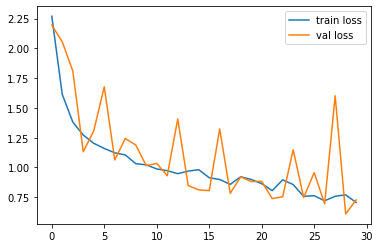

In [ ]:
model_name = 'link_res'
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc,val_acc)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.7104	0.6722
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.8776	0.8261
16	Sand_Beach 0.1461	0.1526
17	Water_Lake 0.8769	0.8609
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.1318	0.2119
Average: 0.1444,0.1434


## Train LinkNet **2**

In [ ]:
lr = 1e-4

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr2'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.84, Val loss: 2.66
Epoch 1: Train Loss: 2.67, Val loss: 2.63
Epoch 2: Train Loss: 2.55, Val loss: 2.47
Epoch 3: Train Loss: 2.47, Val loss: 2.16
Epoch 4: Train Loss: 2.36, Val loss: 2.02
Epoch 5: Train Loss: 2.27, Val loss: 1.92
Epoch 6: Train Loss: 2.19, Val loss: 1.91
Epoch 7: Train Loss: 2.10, Val loss: 1.82
Epoch 8: Train Loss: 2.03, Val loss: 1.89
Epoch 9: Train Loss: 1.96, Val loss: 1.62
Epoch 10: Train Loss: 1.88, Val loss: 1.66
Epoch 11: Train Loss: 1.84, Val loss: 1.53
Epoch 12: Train Loss: 1.76, Val loss: 1.49
Epoch 13: Train Loss: 1.74, Val loss: 1.46
Epoch 14: Train Loss: 1.65, Val loss: 1.41
Epoch 15: Train Loss: 1.60, Val loss: 1.39
Epoch 16: Train Loss: 1.54, Val loss: 1.32
Epoch 17: Train Loss: 1.48, Val loss: 1.38
Epoch 18: Train Loss: 1.45, Val loss: 1.30
Epoch 19: Train Loss: 1.42, Val loss: 1.23
Epoch 20: Train Loss: 1.36, Val loss: 1.16
Epoch 21: Train Loss: 1.32, Val loss: 1.21
Epoch 22: Train Loss: 1.26, Val loss: 1.11
Epoch 23: Train Loss:

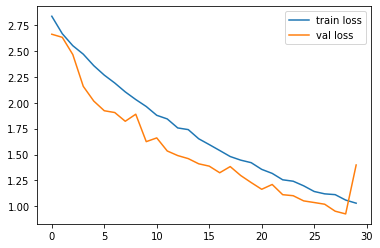

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_2 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_2 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_2, val_acc_2)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.5499	0.4963
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.9580	0.9274
16	Sand_Beach 0.0000	0.0000
17	Water_Lake 0.0000	0.0000
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.0000	0.0000
Average: 0.0794,0.0749


## Train LinkNet 3

In [ ]:
lr = 1e-2

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr3'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 1.74, Val loss: 10.01
Epoch 1: Train Loss: 1.39, Val loss: 2.40
Epoch 2: Train Loss: 1.26, Val loss: 1.07
Epoch 3: Train Loss: 1.23, Val loss: 1.38
Epoch 4: Train Loss: 1.21, Val loss: 1.02
Epoch 5: Train Loss: 1.18, Val loss: 1.16
Epoch 6: Train Loss: 1.17, Val loss: 1.01
Epoch 7: Train Loss: 1.14, Val loss: 1.03
Epoch 8: Train Loss: 1.06, Val loss: 0.88
Epoch 9: Train Loss: 1.04, Val loss: 0.91
Epoch 10: Train Loss: 1.00, Val loss: 1.18
Epoch 11: Train Loss: 1.01, Val loss: 1.22
Epoch 12: Train Loss: 1.05, Val loss: 1.52
Epoch 13: Train Loss: 0.99, Val loss: 0.95
Epoch 14: Train Loss: 0.98, Val loss: 0.92
Epoch 15: Train Loss: 0.96, Val loss: 0.91
Epoch 16: Train Loss: 0.92, Val loss: 0.77
Epoch 17: Train Loss: 0.92, Val loss: 1.30
Epoch 18: Train Loss: 0.92, Val loss: 0.76
Epoch 19: Train Loss: 0.89, Val loss: 0.82
Epoch 20: Train Loss: 0.85, Val loss: 1.40
Epoch 21: Train Loss: 0.86, Val loss: 0.70
Epoch 22: Train Loss: 0.84, Val loss: 0.98
Epoch 23: Train Loss

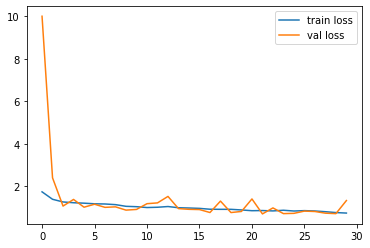

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_3 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_3 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_3, val_acc_3)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9169	0.9089
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0708	0.0770
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.7534	0.7816
16	Sand_Beach 0.2633	0.1682
17	Water_Lake 0.5343	0.5657
18	Water_Pond 0.0012	0.0000
19	Asphalt 0.1340	0.1976
Average: 0.1407,0.1420


## Train LinkNet 4

In [ ]:
lr = 1e-4
num_epochs = 50

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr4'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.85, Val loss: 2.66
Epoch 1: Train Loss: 2.70, Val loss: 2.63
Epoch 2: Train Loss: 2.58, Val loss: 2.57
Epoch 3: Train Loss: 2.49, Val loss: 2.18
Epoch 4: Train Loss: 2.37, Val loss: 2.04
Epoch 5: Train Loss: 2.29, Val loss: 2.00
Epoch 6: Train Loss: 2.18, Val loss: 1.88
Epoch 7: Train Loss: 2.11, Val loss: 1.96
Epoch 8: Train Loss: 2.01, Val loss: 1.84
Epoch 9: Train Loss: 1.95, Val loss: 1.55
Epoch 10: Train Loss: 1.90, Val loss: 1.58
Epoch 11: Train Loss: 1.80, Val loss: 1.55
Epoch 12: Train Loss: 1.74, Val loss: 1.48
Epoch 13: Train Loss: 1.68, Val loss: 1.40
Epoch 14: Train Loss: 1.61, Val loss: 1.39
Epoch 15: Train Loss: 1.55, Val loss: 1.82
Epoch 16: Train Loss: 1.51, Val loss: 1.35
Epoch 17: Train Loss: 1.46, Val loss: 1.22
Epoch 18: Train Loss: 1.40, Val loss: 1.15
Epoch 19: Train Loss: 1.37, Val loss: 1.24
Epoch 20: Train Loss: 1.32, Val loss: 1.12
Epoch 21: Train Loss: 1.30, Val loss: 1.08
Epoch 22: Train Loss: 1.24, Val loss: 1.07
Epoch 23: Train Loss:

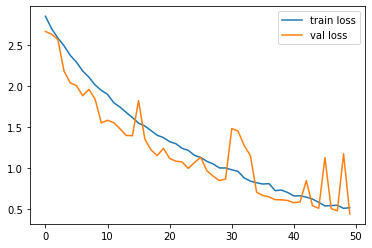

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_4 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_4 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_4, val_acc_4)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9681	0.9332
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.9826	0.9548
16	Sand_Beach 0.9745	0.9093
17	Water_Lake 0.9921	0.9448
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.1421	0.1285
Average: 0.2136,0.2037


## Train LinkNet 5

In [ ]:
lr = 1e-3
num_epochs = 80

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr5'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.43, Val loss: 2.35
Epoch 1: Train Loss: 1.83, Val loss: 2.23
Epoch 2: Train Loss: 1.55, Val loss: 1.92
Epoch 3: Train Loss: 1.40, Val loss: 1.85
Epoch 4: Train Loss: 1.29, Val loss: 1.11
Epoch 5: Train Loss: 1.27, Val loss: 1.50
Epoch 6: Train Loss: 1.21, Val loss: 1.05
Epoch 7: Train Loss: 1.10, Val loss: 0.85
Epoch 8: Train Loss: 1.02, Val loss: 0.79
Epoch 9: Train Loss: 0.97, Val loss: 0.95
Epoch 10: Train Loss: 0.95, Val loss: 1.13
Epoch 11: Train Loss: 0.93, Val loss: 0.72
Epoch 12: Train Loss: 0.90, Val loss: 0.68
Epoch 13: Train Loss: 0.89, Val loss: 0.73
Epoch 14: Train Loss: 0.83, Val loss: 0.64
Epoch 15: Train Loss: 0.88, Val loss: 0.68
Epoch 16: Train Loss: 0.82, Val loss: 0.84
Epoch 17: Train Loss: 0.84, Val loss: 0.81
Epoch 18: Train Loss: 0.85, Val loss: 0.73
Epoch 19: Train Loss: 0.80, Val loss: 0.61
Epoch 20: Train Loss: 0.80, Val loss: 0.69
Epoch 21: Train Loss: 0.78, Val loss: 0.66
Epoch 22: Train Loss: 0.71, Val loss: 0.73
Epoch 23: Train Loss:

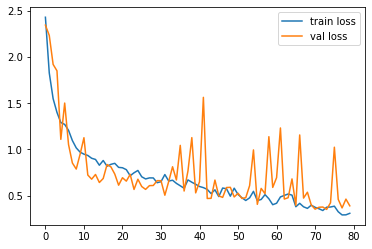

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_5 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_5 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_5, val_acc_5)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9693	0.9458
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.7830	0.6154
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.9512	0.8037
16	Sand_Beach 0.8685	0.7435
17	Water_Lake 0.8886	0.7525
18	Water_Pond 0.6964	0.4238
19	Asphalt 0.9514	0.8270
Average: 0.3215,0.2690


## Train LinkNet 6

In [ ]:
lr = 1e-3
num_epochs = 80
weight_decay=1e-4

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr6'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.40, Val loss: 2.38
Epoch 1: Train Loss: 1.80, Val loss: 2.20
Epoch 2: Train Loss: 1.50, Val loss: 1.28
Epoch 3: Train Loss: 1.33, Val loss: 1.07
Epoch 4: Train Loss: 1.21, Val loss: 1.09
Epoch 5: Train Loss: 1.21, Val loss: 0.95
Epoch 6: Train Loss: 1.11, Val loss: 1.04
Epoch 7: Train Loss: 1.09, Val loss: 0.95
Epoch 8: Train Loss: 1.08, Val loss: 0.94
Epoch 9: Train Loss: 1.07, Val loss: 1.10
Epoch 10: Train Loss: 1.02, Val loss: 0.90
Epoch 11: Train Loss: 0.98, Val loss: 0.81
Epoch 12: Train Loss: 0.91, Val loss: 0.92
Epoch 13: Train Loss: 0.89, Val loss: 0.95
Epoch 14: Train Loss: 0.89, Val loss: 0.80
Epoch 15: Train Loss: 0.84, Val loss: 1.59
Epoch 16: Train Loss: 0.89, Val loss: 0.69
Epoch 17: Train Loss: 0.81, Val loss: 0.75
Epoch 18: Train Loss: 0.84, Val loss: 0.86
Epoch 19: Train Loss: 0.76, Val loss: 0.76
Epoch 20: Train Loss: 0.83, Val loss: 0.80
Epoch 21: Train Loss: 0.78, Val loss: 0.62
Epoch 22: Train Loss: 0.74, Val loss: 0.56
Epoch 23: Train Loss:

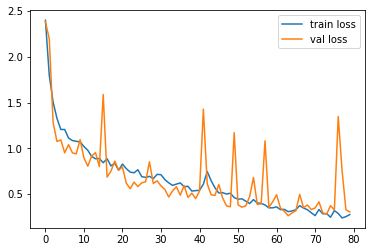

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr,weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_6 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_6 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_6, val_acc_6)

idx	Classes		train	val
2	RoadMarkings 0.0165	0.0269
3	Tree 0.8877	0.8610
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.6885	0.5687
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.9597	0.9291
16	Sand_Beach 0.9614	0.8871
17	Water_Lake 0.9785	0.8921
18	Water_Pond 0.4324	0.1817
19	Asphalt 0.9743	0.8902
Average: 0.3105,0.2756


## Train LinkNet 7

In [ ]:
lr = 1e-3
num_epochs = 40
weight_decay=1e-3

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr7'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.58, Val loss: 2.42
Epoch 1: Train Loss: 1.93, Val loss: 2.18
Epoch 2: Train Loss: 1.57, Val loss: 2.01
Epoch 3: Train Loss: 1.43, Val loss: 1.26
Epoch 4: Train Loss: 1.33, Val loss: 1.68
Epoch 5: Train Loss: 1.25, Val loss: 1.29
Epoch 6: Train Loss: 1.17, Val loss: 1.06
Epoch 7: Train Loss: 1.14, Val loss: 3.69
Epoch 8: Train Loss: 1.12, Val loss: 0.93
Epoch 9: Train Loss: 1.12, Val loss: 1.07
Epoch 10: Train Loss: 1.09, Val loss: 1.92
Epoch 11: Train Loss: 1.06, Val loss: 1.74
Epoch 12: Train Loss: 1.06, Val loss: 1.02
Epoch 13: Train Loss: 1.02, Val loss: 1.14
Epoch 14: Train Loss: 1.02, Val loss: 1.82
Epoch 15: Train Loss: 1.00, Val loss: 2.11
Epoch 16: Train Loss: 0.96, Val loss: 0.79
Epoch 17: Train Loss: 0.98, Val loss: 0.90
Epoch 18: Train Loss: 0.96, Val loss: 0.90
Epoch 19: Train Loss: 0.91, Val loss: 0.89
Epoch 20: Train Loss: 0.91, Val loss: 1.52
Epoch 21: Train Loss: 0.88, Val loss: 0.73
Epoch 22: Train Loss: 0.90, Val loss: 1.75
Epoch 23: Train Loss:

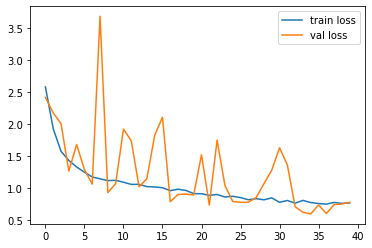

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr,weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_7 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_7 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_7, val_acc_7)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9519	0.9732
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.8443	0.8604
16	Sand_Beach 0.2008	0.1909
17	Water_Lake 0.8124	0.7417
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.0047	0.0042
Average: 0.1481,0.1458


## Train LinkNet 8

In [ ]:
lr = 1e-3
num_epochs = 80
weight_decay=1e-5

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr8'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.42, Val loss: 2.58
Epoch 1: Train Loss: 1.78, Val loss: 2.44
Epoch 2: Train Loss: 1.48, Val loss: 1.33
Epoch 3: Train Loss: 1.34, Val loss: 1.22
Epoch 4: Train Loss: 1.22, Val loss: 1.42
Epoch 5: Train Loss: 1.20, Val loss: 1.06
Epoch 6: Train Loss: 1.11, Val loss: 1.55
Epoch 7: Train Loss: 1.07, Val loss: 1.08
Epoch 8: Train Loss: 1.01, Val loss: 0.89
Epoch 9: Train Loss: 0.96, Val loss: 0.89
Epoch 10: Train Loss: 0.94, Val loss: 0.92
Epoch 11: Train Loss: 0.93, Val loss: 1.04
Epoch 12: Train Loss: 0.84, Val loss: 0.82
Epoch 13: Train Loss: 0.85, Val loss: 1.36
Epoch 14: Train Loss: 0.88, Val loss: 0.97
Epoch 15: Train Loss: 0.80, Val loss: 1.38
Epoch 16: Train Loss: 0.82, Val loss: 0.78
Epoch 17: Train Loss: 0.80, Val loss: 0.75
Epoch 18: Train Loss: 0.82, Val loss: 0.81
Epoch 19: Train Loss: 0.80, Val loss: 0.66
Epoch 20: Train Loss: 0.73, Val loss: 0.71
Epoch 21: Train Loss: 0.75, Val loss: 0.73
Epoch 22: Train Loss: 0.74, Val loss: 1.79
Epoch 23: Train Loss:

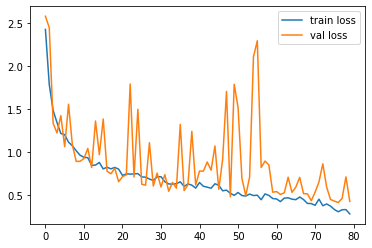

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr,weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_8 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_8 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_8, val_acc_8)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.0000	0.0000
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.0000	0.0000
16	Sand_Beach 0.0000	0.0000
17	Water_Lake 0.0000	0.0000
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.0000	0.0000
Average: 0.0000,0.0000


## Train LinkNet 9 (SGD)

In [ ]:
lr = 1e-3
num_epochs = 80
momentum = 0.9

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr9'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.92, Val loss: 2.63
Epoch 1: Train Loss: 2.82, Val loss: 2.57
Epoch 2: Train Loss: 2.72, Val loss: 2.45
Epoch 3: Train Loss: 2.62, Val loss: 2.35
Epoch 4: Train Loss: 2.50, Val loss: 2.25
Epoch 5: Train Loss: 2.38, Val loss: 2.14
Epoch 6: Train Loss: 2.27, Val loss: 2.02
Epoch 7: Train Loss: 2.15, Val loss: 1.90
Epoch 8: Train Loss: 2.03, Val loss: 1.79
Epoch 9: Train Loss: 1.96, Val loss: 1.69
Epoch 10: Train Loss: 1.87, Val loss: 1.65
Epoch 11: Train Loss: 1.80, Val loss: 1.62
Epoch 12: Train Loss: 1.75, Val loss: 1.53
Epoch 13: Train Loss: 1.70, Val loss: 1.51
Epoch 14: Train Loss: 1.67, Val loss: 1.48
Epoch 15: Train Loss: 1.64, Val loss: 1.46
Epoch 16: Train Loss: 1.58, Val loss: 1.41
Epoch 17: Train Loss: 1.56, Val loss: 1.37
Epoch 18: Train Loss: 1.50, Val loss: 1.36
Epoch 19: Train Loss: 1.49, Val loss: 1.32
Epoch 20: Train Loss: 1.46, Val loss: 1.28
Epoch 21: Train Loss: 1.44, Val loss: 1.26
Epoch 22: Train Loss: 1.40, Val loss: 1.26
Epoch 23: Train Loss:

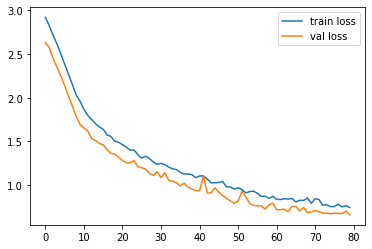

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr,momentum=momentum)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_9 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_9 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_9, val_acc_9)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9571	0.9395
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.9603	0.8883
16	Sand_Beach 0.0643	0.0436
17	Water_Lake 0.0000	0.0000
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.0000	0.0000
Average: 0.1043,0.0985


## Train LinkNet 10

In [ ]:
lr = 1e-2
num_epochs = 80
momentum = 0.9
weight_decay=1e-4

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr10'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.55, Val loss: 2.30
Epoch 1: Train Loss: 1.83, Val loss: 2.15
Epoch 2: Train Loss: 1.63, Val loss: 1.39
Epoch 3: Train Loss: 1.56, Val loss: 1.31
Epoch 4: Train Loss: 1.42, Val loss: 1.18
Epoch 5: Train Loss: 1.30, Val loss: 1.06
Epoch 6: Train Loss: 1.18, Val loss: 0.96
Epoch 7: Train Loss: 1.14, Val loss: 0.96
Epoch 8: Train Loss: 1.04, Val loss: 0.78
Epoch 9: Train Loss: 0.95, Val loss: 0.85
Epoch 10: Train Loss: 0.96, Val loss: 0.80
Epoch 11: Train Loss: 0.92, Val loss: 0.94
Epoch 12: Train Loss: 0.89, Val loss: 0.68
Epoch 13: Train Loss: 0.88, Val loss: 0.70
Epoch 14: Train Loss: 0.82, Val loss: 0.74
Epoch 15: Train Loss: 0.78, Val loss: 0.63
Epoch 16: Train Loss: 0.73, Val loss: 0.60
Epoch 17: Train Loss: 0.75, Val loss: 0.74
Epoch 18: Train Loss: 0.66, Val loss: 0.56
Epoch 19: Train Loss: 0.70, Val loss: 0.65
Epoch 20: Train Loss: 0.62, Val loss: 0.55
Epoch 21: Train Loss: 0.66, Val loss: 0.55
Epoch 22: Train Loss: 0.61, Val loss: 0.52
Epoch 23: Train Loss:

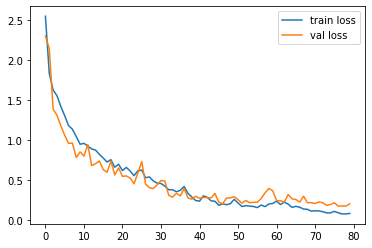

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr,momentum=momentum,weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_10 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_10 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_10, val_acc_10)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9855	0.9768
4	Building 0.3546	0.0165
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.9165	0.6993
14	LowLevelVegetation 0.9259	0.4494
15	Grass_Lawn 0.9881	0.9672
16	Sand_Beach 0.9862	0.9475
17	Water_Lake 0.9956	0.8835
18	Water_Pond 0.9806	0.7623
19	Asphalt 0.9918	0.9137
Average: 0.4276,0.3482


## Train LinkNet 11

In [ ]:
lr = 1e-4
num_epochs = 80
momentum = 0.9
weight_decay=1e-4

#### Load or Create the model

In [ ]:
model_name = 'link_res_lr11'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.94, Val loss: 2.67
Epoch 1: Train Loss: 2.92, Val loss: 2.68
Epoch 2: Train Loss: 2.91, Val loss: 2.68
Epoch 3: Train Loss: 2.90, Val loss: 2.67
Epoch 4: Train Loss: 2.89, Val loss: 2.66
Epoch 5: Train Loss: 2.88, Val loss: 2.65
Epoch 6: Train Loss: 2.87, Val loss: 2.64
Epoch 7: Train Loss: 2.86, Val loss: 2.63
Epoch 8: Train Loss: 2.85, Val loss: 2.62
Epoch 9: Train Loss: 2.84, Val loss: 2.61
Epoch 10: Train Loss: 2.83, Val loss: 2.60
Epoch 11: Train Loss: 2.82, Val loss: 2.59
Epoch 12: Train Loss: 2.81, Val loss: 2.58
Epoch 13: Train Loss: 2.80, Val loss: 2.57
Epoch 14: Train Loss: 2.79, Val loss: 2.57
Epoch 15: Train Loss: 2.78, Val loss: 2.56
Epoch 16: Train Loss: 2.77, Val loss: 2.55
Epoch 17: Train Loss: 2.76, Val loss: 2.54
Epoch 18: Train Loss: 2.75, Val loss: 2.53
Epoch 19: Train Loss: 2.74, Val loss: 2.52
Epoch 20: Train Loss: 2.73, Val loss: 2.51
Epoch 21: Train Loss: 2.72, Val loss: 2.50
Epoch 22: Train Loss: 2.71, Val loss: 2.49
Epoch 23: Train Loss:

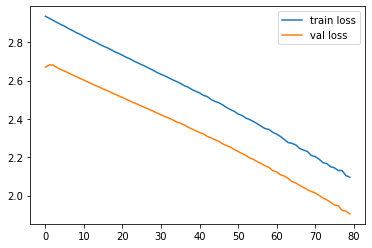

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr,momentum=momentum,weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [ ]:
train_acc_11 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [ ]:
val_acc_11 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [ ]:
print_acc(train_acc_11, val_acc_11)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.0000	0.0000
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.0516	0.0259
16	Sand_Beach 0.0000	0.0000
17	Water_Lake 0.0000	0.0000
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.0000	0.0000
Average: 0.0027,0.0014


## Train LinkNet 12

In [18]:
lr = 1e-3
batch_size=32
num_epochs = 80

#### Load or Create the model

In [19]:
model_name = 'link_res_lr12'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.53, Val loss: 2.25
Epoch 1: Train Loss: 2.14, Val loss: 2.10
Epoch 2: Train Loss: 1.85, Val loss: 1.98
Epoch 3: Train Loss: 1.62, Val loss: 1.92
Epoch 4: Train Loss: 1.48, Val loss: 1.89
Epoch 5: Train Loss: 1.35, Val loss: 1.72
Epoch 6: Train Loss: 1.29, Val loss: 1.12
Epoch 7: Train Loss: 1.19, Val loss: 0.92
Epoch 8: Train Loss: 1.17, Val loss: 0.93
Epoch 9: Train Loss: 1.09, Val loss: 0.89
Epoch 10: Train Loss: 1.01, Val loss: 1.22
Epoch 11: Train Loss: 0.99, Val loss: 1.46
Epoch 12: Train Loss: 0.93, Val loss: 0.82
Epoch 13: Train Loss: 0.93, Val loss: 0.77
Epoch 14: Train Loss: 0.87, Val loss: 1.29
Epoch 15: Train Loss: 0.85, Val loss: 0.72
Epoch 16: Train Loss: 0.80, Val loss: 0.71
Epoch 17: Train Loss: 0.81, Val loss: 0.78
Epoch 18: Train Loss: 0.79, Val loss: 0.63
Epoch 19: Train Loss: 0.71, Val loss: 0.54
Epoch 20: Train Loss: 0.67, Val loss: 1.09
Epoch 21: Train Loss: 0.65, Val loss: 0.58
Epoch 22: Train Loss: 0.68, Val loss: 1.37
Epoch 23: Train Loss:

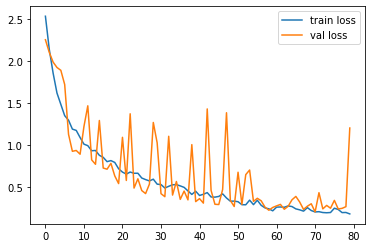

In [20]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [21]:
train_acc_12 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [22]:
val_acc_12 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [23]:
print_acc(train_acc_12, val_acc_12)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9704	0.9399
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.6280	0.4809
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.9789	0.9644
16	Sand_Beach 0.9559	0.8735
17	Water_Lake 0.9902	0.9422
18	Water_Pond 0.8729	0.5441
19	Asphalt 0.9606	0.8535
Average: 0.3346,0.2947


## Train LinkNet 13
batch_size=32

In [24]:
lr = 1e-3
batch_size=32
num_epochs = 100

#### Load or Create the model

In [25]:
model_name = 'link_res_lr13'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.58, Val loss: 2.24
Epoch 1: Train Loss: 2.16, Val loss: 2.10
Epoch 2: Train Loss: 1.83, Val loss: 2.05
Epoch 3: Train Loss: 1.60, Val loss: 1.97
Epoch 4: Train Loss: 1.44, Val loss: 1.88
Epoch 5: Train Loss: 1.29, Val loss: 1.69
Epoch 6: Train Loss: 1.17, Val loss: 0.97
Epoch 7: Train Loss: 1.10, Val loss: 0.95
Epoch 8: Train Loss: 1.06, Val loss: 0.86
Epoch 9: Train Loss: 0.96, Val loss: 0.93
Epoch 10: Train Loss: 0.91, Val loss: 0.69
Epoch 11: Train Loss: 0.84, Val loss: 0.69
Epoch 12: Train Loss: 0.82, Val loss: 0.74
Epoch 13: Train Loss: 0.80, Val loss: 0.80
Epoch 14: Train Loss: 0.77, Val loss: 0.62
Epoch 15: Train Loss: 0.73, Val loss: 0.66
Epoch 16: Train Loss: 0.73, Val loss: 0.77
Epoch 17: Train Loss: 0.72, Val loss: 0.50
Epoch 18: Train Loss: 0.70, Val loss: 0.48
Epoch 19: Train Loss: 0.68, Val loss: 0.65
Epoch 20: Train Loss: 0.67, Val loss: 0.88
Epoch 21: Train Loss: 0.64, Val loss: 0.47
Epoch 22: Train Loss: 0.62, Val loss: 0.50
Epoch 23: Train Loss:

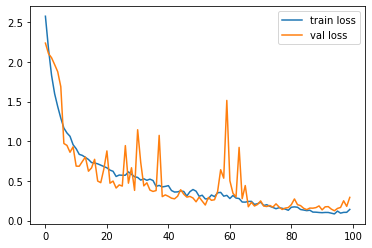

In [26]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [27]:
train_acc_13 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [28]:
val_acc_13 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [29]:
print_acc(train_acc_13, val_acc_13)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9775	0.9558
4	Building 0.3439	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.8949	0.7972
14	LowLevelVegetation 0.8412	0.2209
15	Grass_Lawn 0.7627	0.7796
16	Sand_Beach 0.9653	0.8849
17	Water_Lake 0.9930	0.9847
18	Water_Pond 0.8914	0.3248
19	Asphalt 0.9412	0.8389
Average: 0.4006,0.3046


## Train LinkNet 14

In [30]:
lr = 1e-3
batch_size=32
num_epochs = 100
weight_decay=1e-4

#### Load or Create the model

In [31]:
model_name = 'link_res_lr14'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.56, Val loss: 2.24
Epoch 1: Train Loss: 2.15, Val loss: 2.08
Epoch 2: Train Loss: 1.84, Val loss: 1.95
Epoch 3: Train Loss: 1.60, Val loss: 1.94
Epoch 4: Train Loss: 1.42, Val loss: 1.93
Epoch 5: Train Loss: 1.30, Val loss: 1.65
Epoch 6: Train Loss: 1.19, Val loss: 1.56
Epoch 7: Train Loss: 1.09, Val loss: 0.99
Epoch 8: Train Loss: 1.04, Val loss: 0.91
Epoch 9: Train Loss: 1.01, Val loss: 0.77
Epoch 10: Train Loss: 0.93, Val loss: 0.87
Epoch 11: Train Loss: 0.90, Val loss: 0.87
Epoch 12: Train Loss: 0.89, Val loss: 1.31
Epoch 13: Train Loss: 0.85, Val loss: 0.64
Epoch 14: Train Loss: 0.82, Val loss: 1.10
Epoch 15: Train Loss: 0.82, Val loss: 0.79
Epoch 16: Train Loss: 0.75, Val loss: 0.73
Epoch 17: Train Loss: 0.82, Val loss: 0.57
Epoch 18: Train Loss: 0.77, Val loss: 1.31
Epoch 19: Train Loss: 0.72, Val loss: 0.52
Epoch 20: Train Loss: 0.69, Val loss: 0.60
Epoch 21: Train Loss: 0.67, Val loss: 1.30
Epoch 22: Train Loss: 0.72, Val loss: 0.61
Epoch 23: Train Loss:

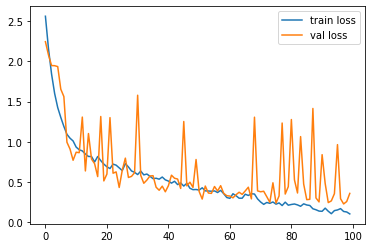

In [32]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [33]:
train_acc_14 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [34]:
val_acc_14 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [35]:
print_acc(train_acc_14, val_acc_14)

idx	Classes		train	val
2	RoadMarkings 0.0003	0.0000
3	Tree 0.9252	0.7823
4	Building 0.7240	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.8632	0.6891
14	LowLevelVegetation 0.8781	0.3398
15	Grass_Lawn 0.9920	0.9680
16	Sand_Beach 0.9350	0.6112
17	Water_Lake 0.9917	0.8923
18	Water_Pond 0.9682	0.7804
19	Asphalt 0.9838	0.9234
Average: 0.4348,0.3151


## Train LinkNet 15

In [36]:
lr = 1e-3
batch_size=32
num_epochs = 40
weight_decay=1e-2

#### Load or Create the model

In [37]:
model_name = 'link_res_lr15'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.62, Val loss: 2.27
Epoch 1: Train Loss: 2.20, Val loss: 2.11
Epoch 2: Train Loss: 1.83, Val loss: 2.02
Epoch 3: Train Loss: 1.53, Val loss: 1.96
Epoch 4: Train Loss: 1.33, Val loss: 1.92
Epoch 5: Train Loss: 1.19, Val loss: 1.38
Epoch 6: Train Loss: 1.11, Val loss: 1.26
Epoch 7: Train Loss: 1.00, Val loss: 0.81
Epoch 8: Train Loss: 0.93, Val loss: 0.75
Epoch 9: Train Loss: 0.90, Val loss: 0.70
Epoch 10: Train Loss: 0.87, Val loss: 0.67
Epoch 11: Train Loss: 0.88, Val loss: 0.84
Epoch 12: Train Loss: 0.82, Val loss: 0.68
Epoch 13: Train Loss: 0.83, Val loss: 0.73
Epoch 14: Train Loss: 0.77, Val loss: 0.57
Epoch 15: Train Loss: 0.75, Val loss: 0.75
Epoch 16: Train Loss: 0.74, Val loss: 0.84
Epoch 17: Train Loss: 0.71, Val loss: 0.57
Epoch 18: Train Loss: 0.66, Val loss: 0.53
Epoch 19: Train Loss: 0.64, Val loss: 0.46
Epoch 20: Train Loss: 0.63, Val loss: 0.45
Epoch 21: Train Loss: 0.65, Val loss: 0.66
Epoch 22: Train Loss: 0.63, Val loss: 0.54
Epoch 23: Train Loss:

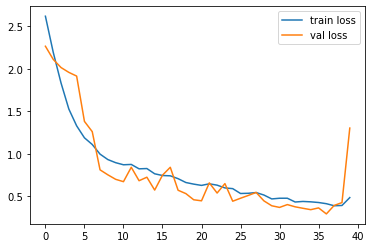

In [38]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [39]:
train_acc_15 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [40]:
val_acc_15 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [41]:
print_acc(train_acc_15, val_acc_15)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.7404	0.5736
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.0000	0.0000
14	LowLevelVegetation 0.0000	0.0000
15	Grass_Lawn 0.6552	0.6542
16	Sand_Beach 0.9100	0.8756
17	Water_Lake 0.4105	0.3886
18	Water_Pond 0.0000	0.0000
19	Asphalt 0.2527	0.2833
Average: 0.1563,0.1461


## Train LinkNet 16
batch_size=64

In [16]:
lr = 1e-3
batch_size=64
num_epochs = 100

#### Load or Create the model

In [17]:
model_name = 'link_res_lr16'
models[model_name] = {
        'model': get_link_resnet_model(),
        'path': f"{folder_path}models/{model_name}_check_points.pt"}

#### Set Optimiazers and Train function

Epoch 0: Train Loss: 2.55, Val loss: 2.32
Epoch 1: Train Loss: 2.30, Val loss: 2.28
Epoch 2: Train Loss: 2.13, Val loss: 2.21
Epoch 3: Train Loss: 1.93, Val loss: 2.15
Epoch 4: Train Loss: 1.75, Val loss: 2.11
Epoch 5: Train Loss: 1.59, Val loss: 2.04
Epoch 6: Train Loss: 1.44, Val loss: 2.06
Epoch 7: Train Loss: 1.36, Val loss: 2.02
Epoch 8: Train Loss: 1.30, Val loss: 1.99
Epoch 9: Train Loss: 1.14, Val loss: 1.96
Epoch 10: Train Loss: 1.06, Val loss: 1.77
Epoch 11: Train Loss: 1.01, Val loss: 1.48
Epoch 12: Train Loss: 0.89, Val loss: 1.42
Epoch 13: Train Loss: 0.87, Val loss: 1.57
Epoch 14: Train Loss: 0.81, Val loss: 1.30
Epoch 15: Train Loss: 0.79, Val loss: 0.83
Epoch 16: Train Loss: 0.73, Val loss: 0.75
Epoch 17: Train Loss: 0.74, Val loss: 1.03
Epoch 18: Train Loss: 0.73, Val loss: 1.20
Epoch 19: Train Loss: 0.82, Val loss: 1.30
Epoch 20: Train Loss: 0.78, Val loss: 0.89
Epoch 21: Train Loss: 0.71, Val loss: 1.18
Epoch 22: Train Loss: 0.67, Val loss: 0.70
Epoch 23: Train Loss:

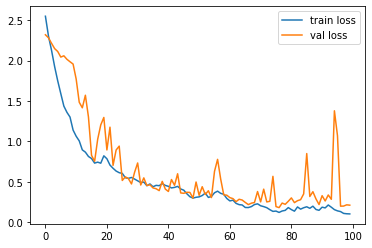

In [18]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, models[model_name]['model'].parameters()), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
loss_values[model_name],accuracy_values[model_name] = train( models[model_name]['path'], {'train':train_loader,'val':val_loader}, models[model_name]['model'], optimizer, loss_fn,scaler)
plt.plot(loss_values[model_name]['train'], label = "train loss")
plt.plot(loss_values[model_name]['val'], label = "val loss")
plt.legend()
plt.show()

### Check Accuarcy

In [19]:
train_acc_16 = check_accuracy(train_loader, models[model_name]['model'], device="cuda", check_type='train')

In [20]:
val_acc_16 = check_accuracy(val_loader, models[model_name]['model'], device="cuda", check_type='val')

In [21]:
print_acc(train_acc_16, val_acc_16)

idx	Classes		train	val
2	RoadMarkings 0.0000	0.0000
3	Tree 0.9833	0.9258
4	Building 0.0000	0.0000
5	Vehicle 0.0000	0.0000
6	Person 0.0000	0.0000
7	LifeguardChair 0.0000	0.0000
8	PicnicTable 0.0000	0.0000
9	BlackWoodPanel 0.0000	0.0000
10	WhiteWoodPanel 0.0000	0.0000
11	OrangeLandingPad 0.0000	0.0000
12	Buoy 0.0000	0.0000
13	Rocks 0.7970	0.5859
14	LowLevelVegetation 0.8551	0.2003
15	Grass_Lawn 0.9712	0.9630
16	Sand_Beach 0.9540	0.8402
17	Water_Lake 0.9799	0.9119
18	Water_Pond 0.9539	0.8523
19	Asphalt 0.9827	0.8908
Average: 0.3935,0.3247


# Test


In [88]:
# LinkNet 6
# lr = 1e-3
# num_epochs = 80
# weight_decay=1e-4
test_acc_6 = check_accuracy(test_loader, models['link_res_lr6']['model'], device="cuda", check_type='test')

In [89]:
print_single_acc(test_acc_6)

idx	Classes		Accuarcy
2	RoadMarkings 0.0822
3	Tree 0.7258
4	Building 0.0000
5	Vehicle 0.0000
6	Person 0.0000
7	LifeguardChair 0.0000
8	PicnicTable 0.0000
9	BlackWoodPanel 0.0000
10	WhiteWoodPanel 0.0000
11	OrangeLandingPad 0.0000
12	Buoy 0.0000
13	Rocks 0.4850
14	LowLevelVegetation 0.0000
15	Grass_Lawn 0.8392
16	Sand_Beach 0.8592
17	Water_Lake 0.9008
18	Water_Pond 0.0891
19	Asphalt 0.8561
Average: 0.2546


In [42]:
# LinkNet 12
# lr = 1e-3
# batch_size=32
# num_epochs = 80
test_acc_12 = check_accuracy(test_loader, models['link_res_lr12']['model'], device="cuda", check_type='test')

In [43]:
print_single_acc(test_acc_12)

idx	Classes		Accuarcy
2	RoadMarkings 0.0000
3	Tree 0.7700
4	Building 0.0000
5	Vehicle 0.0000
6	Person 0.0000
7	LifeguardChair 0.0000
8	PicnicTable 0.0000
9	BlackWoodPanel 0.0000
10	WhiteWoodPanel 0.0000
11	OrangeLandingPad 0.0000
12	Buoy 0.0000
13	Rocks 0.4710
14	LowLevelVegetation 0.0000
15	Grass_Lawn 0.8384
16	Sand_Beach 0.7987
17	Water_Lake 0.9302
18	Water_Pond 0.3617
19	Asphalt 0.7464
Average: 0.2588


In [44]:
# LinkNet 14
# lr = 1e-3
# batch_size=32
# num_epochs = 100
# weight_decay=1e-4
test_acc_14 = check_accuracy(test_loader, models['link_res_lr14']['model'], device="cuda", check_type='test')

In [45]:
print_single_acc(test_acc_14)

idx	Classes		Accuarcy
2	RoadMarkings 0.0002
3	Tree 0.6583
4	Building 0.1469
5	Vehicle 0.0000
6	Person 0.0000
7	LifeguardChair 0.0000
8	PicnicTable 0.0000
9	BlackWoodPanel 0.0000
10	WhiteWoodPanel 0.0000
11	OrangeLandingPad 0.0000
12	Buoy 0.0000
13	Rocks 0.7752
14	LowLevelVegetation 0.1882
15	Grass_Lawn 0.8602
16	Sand_Beach 0.4227
17	Water_Lake 0.8160
18	Water_Pond 0.3796
19	Asphalt 0.6855
Average: 0.2596


In [22]:
# LinkNet 16
# lr = 1e-3
# batch_size=64
# num_epochs = 100
test_acc_16 = check_accuracy(test_loader, models['link_res_lr16']['model'], device="cuda", check_type='test')

In [23]:
print_single_acc(test_acc_16)

idx	Classes		Accuarcy
2	RoadMarkings 0.0000
3	Tree 0.8188
4	Building 0.0000
5	Vehicle 0.0000
6	Person 0.0000
7	LifeguardChair 0.0000
8	PicnicTable 0.0000
9	BlackWoodPanel 0.0000
10	WhiteWoodPanel 0.0000
11	OrangeLandingPad 0.0000
12	Buoy 0.0000
13	Rocks 0.5843
14	LowLevelVegetation 0.2718
15	Grass_Lawn 0.7846
16	Sand_Beach 0.7064
17	Water_Lake 0.8509
18	Water_Pond 0.2522
19	Asphalt 0.8640
Average: 0.2702


# TIMING

In [42]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 1
timings=np.zeros((repetitions,5))
#GPU-WARM-UP
# MEASURE PERFORMANCE
for rep in range(repetitions):
  starter.record()
  check_accuracy(test_loader, models['link_res_lr16']['model'], device=device, check_type='test')
  ender.record()
  # WAIT FOR GPU SYNC
  torch.cuda.synchronize()
  curr_time = starter.elapsed_time(ender)
  timings[rep] = curr_time
  mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(f'{mean_syn//1000}ms')

270.0ms


# Test some images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


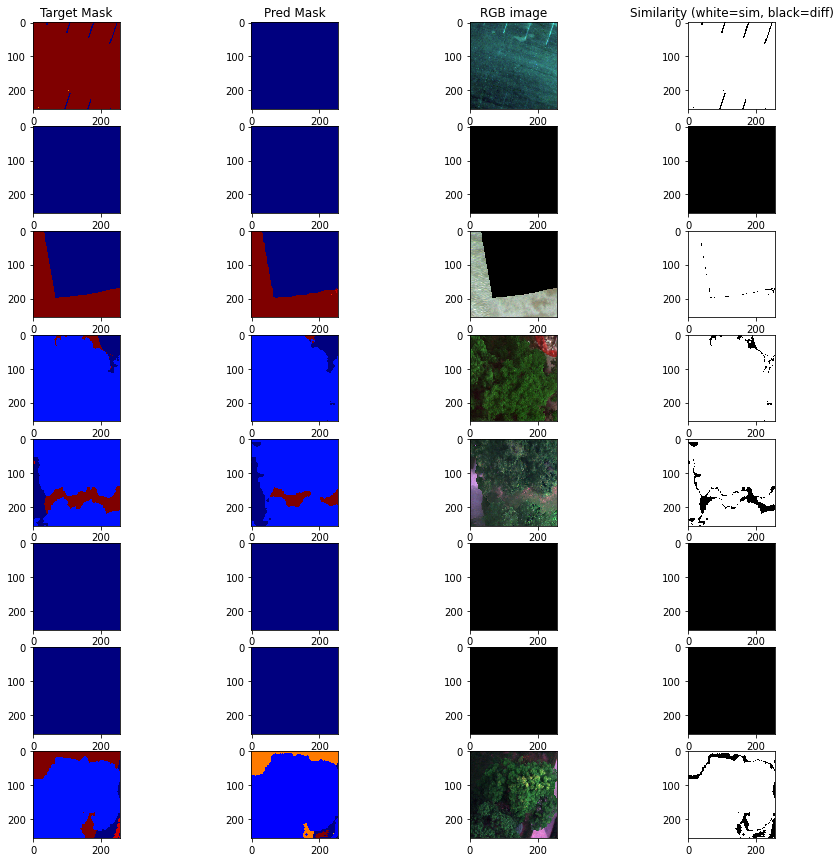

In [40]:
idx = range(1,len(train_loader))
model = models['link_res_lr16']['model']
model.eval()
images = img2plot(model,train_loader, idx)
fig, ax = plt.subplots(int(len(images)/4) + int(len(images)%4 > 0),4)
for i, img in enumerate(images):
    ax[0, 0].set_title("Target Mask")
    ax[0, 1].set_title("Pred Mask")
    ax[0, 2].set_title("RGB image")
    ax[0, 3].set_title("Similarity (white=sim, black=diff)")
    if (i+1)%4 == 0:
      cmap = 'gray'
    else: cmap = 'jet'
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax[int(i/4), i%4].imshow(img,cmap=cmap,interpolation='none')